In [ ]:
!git clone https://github.com/teachers-ai/autonomouscardata.git

Cloning into 'autonomouscardata'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 405 (delta 0), reused 6 (delta 0), pack-reused 399 (from 1)
Receiving objects: 100% (405/405), 485.63 MiB | 24.22 MiB/s, done.
Updating files: 100% (399/399), done.


In [ ]:
# prompt: write a code to read from google drive
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/MyDrive/raspcar/hanuman/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, root_path, transform=None):

        self.root_path = root_path
        self.transform = transform
        self.image_files = os.listdir(root_path)
        self.target = []
        # Iterate over the files and plot them
        for image_file in self.image_files:
          # Read the image file
          if  "L" in image_file :
            y = 0
          elif "R" in image_file:
            y = 1
          elif "F" in image_file:
            y = 2
          self.target.append(y)
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.image_files[idx])
        image = Image.open(img_path).resize((200, 50))
        label = self.target[idx]
        return self.transform(image), label

In [ ]:
transform = transforms.Compose([
    ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

In [ ]:
dataset = CustomImageDataset(root_path, transform=transform)

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
x,y =next(iter(train_dataloader))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(16896, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
net(x)

tensor([[0.0090, 0.1198, 0.0513],
        [0.0066, 0.1153, 0.0446],
        [0.0078, 0.1165, 0.0454],
        [0.0062, 0.1277, 0.0538],
        [0.0052, 0.1314, 0.0531],
        [0.0029, 0.1269, 0.0484],
        [0.0095, 0.1309, 0.0536],
        [0.0050, 0.1228, 0.0437],
        [0.0013, 0.1266, 0.0492],
        [0.0055, 0.1284, 0.0529],
        [0.0076, 0.1316, 0.0523],
        [0.0066, 0.1253, 0.0498],
        [0.0057, 0.1295, 0.0498],
        [0.0041, 0.1268, 0.0475],
        [0.0107, 0.1294, 0.0539],
        [0.0025, 0.1299, 0.0507],
        [0.0109, 0.1301, 0.0552],
        [0.0099, 0.1289, 0.0531],
        [0.0127, 0.1245, 0.0481],
        [0.0099, 0.1230, 0.0454],
        [0.0108, 0.1260, 0.0552],
        [0.0120, 0.1204, 0.0484],
        [0.0111, 0.1204, 0.0530],
        [0.0016, 0.1296, 0.0501],
        [0.0119, 0.1258, 0.0536],
        [0.0118, 0.1230, 0.0511],
        [0.0036, 0.1260, 0.0487],
        [0.0058, 0.1228, 0.0557],
        [0.0109, 0.1183, 0.0425],
        [0.004

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # Use Adam optimizer

In [ ]:
# prompt: write a function for model accuracy

def model_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy


In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 32:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    # calc accuracy
    with torch.no_grad():
      accuracy =[]
      for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        acc= model_accuracy(outputs, labels)
        accuracy.append(acc)

      print(f'Epoch {epoch}, Accuracy: {sum(accuracy)/len(accuracy)}')

print('Finished Training')

Epoch 0, Accuracy: 0.7908163265306122
Epoch 1, Accuracy: 0.8880739795918366
Epoch 2, Accuracy: 0.8848852040816327
Epoch 3, Accuracy: 0.9709821428571429
Epoch 4, Accuracy: 0.9630102040816327
Epoch 5, Accuracy: 0.9776785714285714
Epoch 6, Accuracy: 0.9821428571428571
Epoch 7, Accuracy: 0.9888392857142857
Epoch 8, Accuracy: 0.9933035714285714
Epoch 9, Accuracy: 0.9955357142857143
Finished Training


In [ ]:
model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('pt_model.pt')

In [ ]:
model_new = torch.jit.load('pt_model.pt')
model_new.eval()

SyntaxError: unterminated string literal (detected at line 3) (<ipython-input-71-0ec33b1b199c>, line 3)

In [ ]:
accuracy =[]
for i, data in enumerate(train_dataloader, 0):
  inputs, labels = data
  outputs = model_new(inputs)
  acc= model_accuracy(outputs, labels)
  accuracy.append(acc)

print(f" Accuracy: {sum(accuracy)/len(accuracy)}")

 Accuracy: 0.9955357142857143


In [ ]:
data[0].shape

torch.Size([14, 3, 50, 200])

NameError: name 'img_path' is not defined

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])
#model = torch.load('hanuman1.pth', weights_only=False)

#model.eval()

image = Image.open("/content/drive/MyDrive/raspcar/hanuman/19_img_R.jpg").resize((200, 50))
image =transform(image).unsqueeze(0)
_, predicted = torch.max(model(image), 1)


In [ ]:
predicted.item()


1

In [ ]:
model = torch.jit.load('pt_model1.pt')
model.eval()
image = Image.open("/content/drive/MyDrive/raspcar/hanuman/19_img_R.jpg").resize((200, 50))
image =transform(image).unsqueeze(0)
_, predicted = torch.max(model(image), 1)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])


model.eval()
image =Image.fromarray(image).resize((200, 50))
image =transform(image).unsqueeze(0)
_, predicted = torch.max(model(image), 1)
if predicted.item() == 0:
  print("Left")
elif predicted.item() == 1:
  print("Right")
elif predicted.item() == 2:
  print("Forward")

AttributeError: 'Tensor' object has no attribute '__array_interface__'

In [ ]:
image = cv2.imread("/content/drive/MyDrive/raspcar/hanuman/19_img_R.jpg")

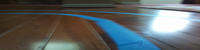

RecursiveScriptModule(
  original_name=Net
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)